<div style="float: block; text-align: center; line-height: 1.7em">
    <span style="font-size: 2em; font-weight: bold"> Fatigue-Sleepiness in Irregular Workloads for Pilots </span><br>
    <span style="font-size: 1.5em"> Exploratory Data Analysis </span><br>
</div>

---

# 1. Loading Required Libraries and Data

In [36]:
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1. Loading data

In [2]:
file = os.path.join('data/processed_features.csv')
df = pd.read_csv(file)
df.head(5)

,Id,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,sleep_duration,...,Position,Num_Sons,Flight_hours,Education,Marital_status,Time_displacement,Classification,Disturbed_sleep,Awakening,Sleep_Fatig
0,P01,5,4.0,AFT,start,others,0,0,8.883333,8.383333,...,CMTE,2,17000.0,PHD,MARRIED,60,INT,13,9,14
1,P01,5,5.0,EVE,middle,others,0,0,8.900000,8.383333,...,CMTE,2,17000.0,PHD,MARRIED,60,INT,13,9,14
2,P01,7,6.0,NI,end,others,0,0,8.916667,8.383333,...,CMTE,2,17000.0,PHD,MARRIED,60,INT,13,9,14
3,P01,7,5.0,NI,start,early-start,0,0,5.450000,7.200000,...,CMTE,2,17000.0,PHD,MARRIED,60,INT,13,9,14
4,P01,4,3.0,MOR,middle,early-start,0,0,5.466667,7.200000,...,CMTE,2,17000.0,PHD,MARRIED,60,INT,13,9,14


---

# 2. Response Variables or Targets

The aim of this work is to quantify sleepiness and fatigue in pilots. So, this problem presents us two response or target variable, Karolinska Sleepiness Scale (kss) and Sam-Perelli fatigue Scale(sps). Both variables are obtained through the use of questionnaries filled in either start, middle and end of workload or duty periods. The tables shown bellow give us what the scales mean.

* **Karolinska Sleepiness Scale (kss)**

| Scale | Original meaning as in google questionnary (Portuguese) | English Translation |
| --- | --- | --- |
| 1 | Muito Alerta | Extremely alert |
| 2 - 3 | Alerta | Alert |
| 4 - 5 | Nem sonolento, nem alerta | Nor sleepy, nor alert |
| 6 - 7 | Sonolento, mas consigo ficar acordado | Drowsy, but I can stay awake |
| 8 - 9 | Muito sonolento, brigando com o sono | Very drowsy, fighting with sleep |

* **Sam-Perelli Fatigue Scale (sps)**

| Scale | Original meaning as in google questionnary (Portuguese) | English Translation |
| --- | --- | --- |
| 1 | Totalmente alerta, bem desperto, extremamente disposto | Fully alert, wide awake, extremely willing |
| 2 | Muito ativo, responsivo, mas não em nível máximo | Very active, responsive, but not at maximum level |
| 3 | Bem, relativamente revigorado | Well, relatively refreshed |
| 4 | Um pouco cansado, não totalmente disposto | A little tired, not quite in the mood |
| 5 | Moderadamente cansado, enfraquecido | Moderately tired, weakened | 
| 6 | Muito cansado, com dificuldade de concentração | Very tired, with difficulty concentrating |
| 7 | Completamente exausto, incapaz de trabalhar efetivamente | Completely exhausted, unable to work effectively |


## 2.2. Experimental Design

Both the sps and kss measurements were taken along three moments of the workloads (start, middle, end and in days-off) and these workloads moments can happen along the some moments along the day (EM, MOR, AFT, EVE, NI). So, the workload are crossed with the moments along the day. Thus, we propose, the following experimental design, depicted bellow:

| | EM | MOR | AFT | EVE | NI |
| --- | -- | --- | --- | --- | --- |
| start | | | | |
| middle | | | | |
| end | | | | |

The measurements were took irregularly, in other words, some participants filled the kss and sps more times than others and not necessarily in consecutive workloads.

## 2.3. Recategorization of Response Variables

Kss and sps scales consists of integer numbers ranging from 1 to 9 and 1 to 7 respectively, that cannot be taken as a continuous result, but as ordinal one. Thinking in terms of modelling it is simpler to reduce this result from 9 or 7 categories to 2 categories. Previous works using the same scales, but for railway workers, use the same approach, due to simplicity, assertiveness and easy interpretation of results.

In this approach we obtain the following:

* **Karolinska scale dichotomized ( Excessive Sleepiness indicator - kssd)**

| Scale Range | Meaning | New Value |
| --- | --- | --- |
| 1 - 6 | Normal | 0 |
| 7 - 9 | Excessive Sleepiness | 1 |

* **Sam-Perelli scale dichotomized (Severe Fatigue indicator - spsd)**

| Scale Range | Meaning | New Value |
| --- | --- | --- |
| 1 - 4 | Normal | 0 |
| 5 - 7 | Severe Fatigue | 1 |



In [3]:
# Applying the rule

df['kssd'] = df['kss'].apply(lambda x: 1 if x >= 7 else 0)
df['spsd'] = df['sps'].apply(lambda x: 1 if x >= 5 else 0)

## 2.4. Getting only working days

The measurements were taken in both workings days and days-off, so the data base were divided to analyze only working days and days off.

In [4]:
working_df = df[df['workload_moment'].isin(['start','middle','end'])]
working_df.head(5)

,Id,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,sleep_duration,...,Flight_hours,Education,Marital_status,Time_displacement,Classification,Disturbed_sleep,Awakening,Sleep_Fatig,kssd,spsd
0,P01,5,4.0,AFT,start,others,0,0,8.883333,8.383333,...,17000.0,PHD,MARRIED,60,INT,13,9,14,0,0
1,P01,5,5.0,EVE,middle,others,0,0,8.900000,8.383333,...,17000.0,PHD,MARRIED,60,INT,13,9,14,0,1
2,P01,7,6.0,NI,end,others,0,0,8.916667,8.383333,...,17000.0,PHD,MARRIED,60,INT,13,9,14,1,1
3,P01,7,5.0,NI,start,early-start,0,0,5.450000,7.200000,...,17000.0,PHD,MARRIED,60,INT,13,9,14,1,1
4,P01,4,3.0,MOR,middle,early-start,0,0,5.466667,7.200000,...,17000.0,PHD,MARRIED,60,INT,13,9,14,0,0


## 2.5. Occurrences of Excessive Sleepiness and Severe Fatigue

### 2.5.1. Function Display Side-by-side

In [5]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").format(precision=2)\
                          .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### 2.5.2. Workload Moment & Filling Time

In [6]:
# Workload Moment
x1 = pd.crosstab(working_df['kssd'], working_df['workload_moment'], rownames=['Sleepiness'], colnames=['Workload'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['workload_moment'], rownames=['Fatigue'], colnames=['Workload'], margins=True, normalize='columns')

# Display
display_side_by_side( [x1,x2], ['(a) Workload Moment-Excessive Sleepiness', '(b) Workload Moment-Severe Fatigue'] )
print(''); print('')

# filling time
x1 = pd.crosstab(working_df['kssd'], working_df['quest_fill_hour'], rownames=['Sleepiness'], colnames=['Filling Time'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['quest_fill_hour'], rownames=['Fatigue'], colnames=['Filling Time'], margins=True, normalize='columns')

# Display
display_side_by_side( [x1,x2], ['(c) Filling Time Excessive Sleepiness', '(d) Filling Time Severe Fatigue'] )
print(''); print('')

Workload,end,middle,start,All
Sleepiness,,,,
0,0.66,0.87,0.92,0.81
1,0.34,0.13,0.08,0.19
Workload,end,middle,start,All
Fatigue,,,,
0,0.57,0.83,0.92,0.77
1,0.43,0.17,0.08,0.23


Filling Time,AFT,EM,EVE,MOR,NI,All
Sleepiness,,,,,,
0,0.89,0.84,0.80,0.85,0.67,0.81
1,0.11,0.16,0.20,0.15,0.33,0.19
Filling Time,AFT,EM,EVE,MOR,NI,All
Fatigue,,,,,,
0,0.87,0.83,0.71,0.81,0.63,0.77
1,0.13,0.17,0.29,0.19,0.37,0.23


Contingencies tables between Excessive Sleepiness (a & c) and Severe Fatigue (b & d) with Workload Moment (a & b) and Filling Time (c & d) are shown above in terms of relative frequency. We can see the following patterns:

* Both excessive sleepiness and severe fatigue tend to be more frequently during the end of workload than in the middle or start;

* Both excessive sleepiness and severe fatigue tend to be more frequently during the NI (Night period, between 00:00 and 05:59) period than in oher periods;

* The severity of fatigue and excessiveness of sleepiness rises from start to the end of workload;

### 2.5.3 - Workload Types

In [8]:
# filling time
x1 = pd.crosstab(working_df['kssd'], working_df['workload_type'], rownames=['Sleepiness'], colnames=['workload_type'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['workload_type'], rownames=['Fatigue'], colnames=['workload_type'], margins=True, normalize='columns')

# Display
print(''); print('')
display_side_by_side( [x1,x2], ['(a) Workload Type Excessive Sleepiness', '(d) Workload Type Severe Fatigue'] )
print(''); print('')

workload_type,early-start,night,others,All
Sleepiness,,,,
0,0.87,0.74,0.86,0.81
1,0.13,0.26,0.14,0.19
workload_type,early-start,night,others,All
Fatigue,,,,
0,0.87,0.68,0.80,0.77
1,0.13,0.32,0.20,0.23


The table above shows contingencies tables between excessive sleepiness (a) and severe fatigue (b) with workload types. The following patterns can be seen:

* Night routines (Workloads comprehending the night period or between 00:00 and 05:59), presents the greater frequency of both, excessive sleepiness and severe fatigue;

* In terms of occurrence of excessiveness of slepiness, no diffeerences is found between early-start and others modalities;

* However, for occurrence of severity of fatigue, early-start (workloads comprehending early-start period or between 06:00 and 07:59) routine have the small relative frequency of occurrence.

### 2.5.4. Previous Workload Types

In [10]:
# filling time
x1 = pd.crosstab(working_df['kssd'], working_df['workload_type_prev_es'], rownames=['Sleepiness'], colnames=['workload_type'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['workload_type_prev_es'], rownames=['Fatigue'], colnames=['workload_type'], margins=True, normalize='columns')

# Display
print(''); print('')
display_side_by_side( [x1,x2], ['(a) Previous ES Excessive Sleepiness', '(b) Previous ES Type Severe Fatigue'] )
print(''); print('')

# filling time
x1 = pd.crosstab(working_df['kssd'], working_df['workload_type_prev_nt'], rownames=['Sleepiness'], colnames=['workload_type'], margins=True, normalize='columns')
x2 = pd.crosstab(working_df['spsd'], working_df['workload_type_prev_nt'], rownames=['Fatigue'], colnames=['workload_type'], margins=True, normalize='columns')

# Display
display_side_by_side( [x1,x2], ['(c) Previous NT Excessive Sleepiness', '(d) Previous NT Type Severe Fatigue'] )
print(''); print('')

workload_type,0,1,2,3,All
Sleepiness,,,,,
0,0.81,0.80,0.97,0.92,0.81
1,0.19,0.20,0.03,0.08,0.19
workload_type,0,1,2,3,All
Fatigue,,,,,
0,0.76,0.82,0.86,0.92,0.77
1,0.24,0.18,0.14,0.08,0.23


workload_type,0,1,2,All
Sleepiness,,,,
0,0.82,0.78,0.82,0.81
1,0.18,0.22,0.18,0.19
workload_type,0,1,2,All
Fatigue,,,,
0,0.79,0.70,0.76,0.77
1,0.21,0.30,0.24,0.23


* For previous Early-Start modality (a & b) we not found relative frequencies for excessive sleepiness or sever fatigue that are above non previous early-start modality (0);

* For previous Night modality (c & d), we found that for workloads preceded by one previous night (1) workloads the relative frequency of excessive sleepiness and severe fatigue are greater than non previos night modality (0).

### 2.5.5. Sleep duration before workload (a terminar)

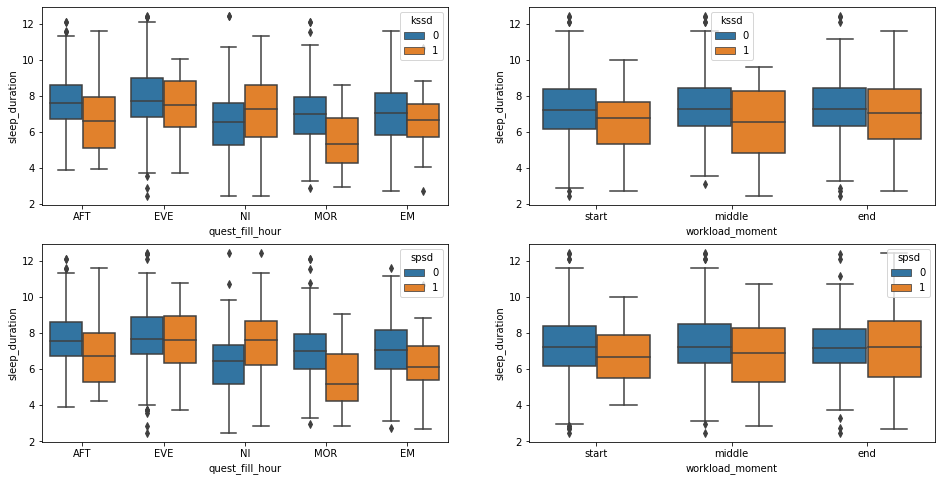

In [48]:
temp = working_df[['kssd','spsd','quest_fill_hour', 'workload_moment', 'sleep_duration']]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(16,8))
sns.boxplot(data = temp, x = 'quest_fill_hour', y = 'sleep_duration', hue = 'kssd', ax = ax[0,0])
sns.boxplot(data = temp, x = 'workload_moment', y = 'sleep_duration', hue = 'kssd', ax = ax[0,1])

sns.boxplot(data = temp, x = 'quest_fill_hour', y = 'sleep_duration', hue = 'spsd', ax = ax[1,0])
sns.boxplot(data = temp, x = 'workload_moment', y = 'sleep_duration', hue = 'spsd', ax = ax[1,1])

plt.show()

### 2.5.5. Number of Naps

In [34]:
x1 = pd.crosstab(working_df['kssd'], working_df['nap_number'], rownames=['Sleepiness'], 
                 colnames=['nap_number'], margins=True, normalize='columns')

x2 = pd.crosstab(working_df['spsd'], working_df['nap_number'], rownames=['Fatigue'], 
                 colnames=['nap_number'], margins=True, normalize='columns')

print(''); print('')
display_side_by_side( [x1,x2], ['(a) # Naps During Workload - Excessive Sleepiness', '(b) # Naps During Workload - Severe Fatigue'] )
print(''); print('')

nap_number,0,1,2,All
Sleepiness,,,,
0,0.85,0.73,0.79,0.81
1,0.15,0.27,0.21,0.19
nap_number,0,1,2,All
Fatigue,,,,
0,0.80,0.71,0.66,0.77
1,0.20,0.29,0.34,0.23


* The relative frequency for excessive sleepiness for pilots who took at least 1 nap is greater than for whom didn't take. This can indicate that as drowsy is the pilot during its workload or duty period more prone is he/she to take a nap.

* For severe fatigue, we found a pattern of raise in relative frequencies as the number of naps raise, this indicates that as fatigated is the pilot during its workload or duty period more prone is he/she to take a nap.

* **To study the effectiveness of naps during workloads, we need to observe the kss and sps before and after the nap**

In [14]:
working_df.columns

Index(['Id', 'kss', 'sps', 'quest_fill_hour', 'workload_moment',
       'workload_type', 'workload_type_prev_es', 'workload_type_prev_nt',
       'workload_length', 'sleep_duration', 'time_awake', 'nap_number',
       'nap_duration', 'Sex', 'Position', 'Num_Sons', 'Flight_hours',
       'Education', 'Marital_status', 'Time_displacement', 'Classification',
       'Disturbed_sleep', 'Awakening', 'Sleep_Fatig', 'kssd', 'spsd'],
      dtype='object')

In [25]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM

import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("kss ~ quest_fill_hour + workload_moment", working_df, groups=working_df["Id"], re_formula = '~workload_moment')
# md = smf.mixedlm("kss ~ workload_moment*quest_fill_hour", working_df, groups=working_df["Id"])
mdf = md.fit()
print(mdf.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                               Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               kss       
No. Observations:                 1079                  Method:                           REML      
No. Groups:                       48                    Scale:                            2.4354    
Min. group size:                  2                     Log-Likelihood:                   -2072.1140
Max. group size:                  39                    Converged:                        Yes       
Mean group size:                  22.5                                                              
----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Intercept             

In [30]:
md = smf.mixedlm("kss ~ quest_fill_hour", working_df, groups=working_df["Id"], re_formula = '~workload_moment')
# md = smf.mixedlm("kss ~ workload_moment*quest_fill_hour", working_df, groups=working_df["Id"])
mdf = md.fit()
print(mdf.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               kss       
No. Observations:                1079                  Method:                           REML      
No. Groups:                      48                    Scale:                            2.4267    
Min. group size:                 2                     Log-Likelihood:                   -2110.3798
Max. group size:                 39                    Converged:                        Yes       
Mean group size:                 22.5                                                              
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

In [81]:
# working_df.loc[working_df['workload_moment'].isin(['middle','start']), 'workload_moment'] = 'Aother'

md = smf.mixedlm("kss ~ quest_fill_hour + workload_moment", working_df, groups=working_df["Id"])
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     kss       
No. Observations:      1079        Method:                 REML      
No. Groups:            48          Scale:                  2.4966    
Min. group size:       2           Log-Likelihood:         -2074.7298
Max. group size:       39          Converged:              Yes       
Mean group size:       22.5                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  4.867    0.164  29.668 0.000  4.546  5.189
quest_fill_hour[T.EM]      0.791    0.190   4.175 0.000  0.420  1.163
quest_fill_hour[T.EVE]     0.533    0.142   3.748 0.000  0.254  0.812
quest_fill_hour[T.MOR]     0.459    0.143   3.206 0.001  0.178  0.739
quest_fill_hour[T.NI]      1.750    

ok
ERROR! Session/line number was not unique in database. History logging moved to new session 312
